In [1]:
 
 # Multi-class classification of EEG data using machine learning

 
 # Cell 1: Import Libraries

# %%
import mne
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from scipy import signal
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")


✓ All libraries imported successfully


In [2]:
# %% [markdown]
# ### Cell 2: Setup Dataset Path and Load Metadata

# %%
# === Dataset root ===
root = Path("/home/aditya11/Documents/playground/projects/BE_proj/the_eeg_lab/data/datasets/ds004504")

# Load participants.tsv for labels
participants_file = root / "participants.tsv"
participants = pd.read_csv(participants_file, sep="\t")
labels_dict = dict(zip(participants["participant_id"], participants["Group"]))

print("Dataset Information:")
print(f"Total subjects: {len(participants)}")
print(f"\nClass distribution:")
print(participants['Group'].value_counts())
print(f"\nFirst few rows:")
print(participants.head())

# %% [markdown]

Dataset Information:
Total subjects: 88

Class distribution:
Group
A    36
C    29
F    23
Name: count, dtype: int64

First few rows:
  participant_id Gender  Age Group  MMSE
0        sub-001      F   57     A    16
1        sub-002      F   78     A    22
2        sub-003      M   70     A    14
3        sub-004      F   67     A    20
4        sub-005      M   70     A    22


In [3]:
# ### Cell 3: Verify Directory Structure

# %%
print("Verifying directory structure...")
print(f"Root exists: {root.exists()}")
print(f"Derivatives exists: {(root / 'derivatives').exists()}")

sub_folders = list((root / "derivatives").glob("sub-*"))
print(f"\nFound {len(sub_folders)} subject folders")

if sub_folders:
    # Check first subject
    first_sub = sub_folders[0]
    print(f"\nFirst subject: {first_sub.name}")
    print(f"EEG folder exists: {(first_sub / 'eeg').exists()}")
    eeg_files = list((first_sub / "eeg").glob("*.set"))
    print(f"EEG files found: {len(eeg_files)}")
    if eeg_files:
        print(f"First file: {eeg_files[0].name}")
        
        # Try loading one file
        try:
            raw = mne.io.read_raw_eeglab(eeg_files[0], preload=True, verbose=False)
            print(f"\n✓ Successfully loaded test file:")
            print(f"  - Channels: {raw.info['nchan']}")
            print(f"  - Duration: {raw.times[-1]:.1f}s")
            print(f"  - Sampling rate: {raw.info['sfreq']} Hz")
        except Exception as e:
            print(f"\n✗ Error loading test file: {e}")

# %% [markdown]

Verifying directory structure...
Root exists: True
Derivatives exists: True

Found 88 subject folders

First subject: sub-049
EEG folder exists: True
EEG files found: 1
First file: sub-049_task-eyesclosed_eeg.set

✓ Successfully loaded test file:
  - Channels: 19
  - Duration: 780.2s
  - Sampling rate: 500.0 Hz


In [4]:
# ### Cell 4: Define Enhanced Feature Extraction Function

# %%
def extract_enhanced_features(raw):
    """Extract comprehensive feature set from EEG"""
    
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'low_alpha': (8, 10),
        'high_alpha': (10, 13),
        'low_beta': (13, 20),
        'high_beta': (20, 30)
    }
    
    raw_filt = raw.copy().filter(0.5, 30., fir_design='firwin')
    epochs = mne.make_fixed_length_epochs(raw_filt, duration=2.0, preload=True)
    
    # PSD features
    psds = epochs.compute_psd(method='welch', fmin=0.5, fmax=30, n_fft=512)
    psds_data = psds.get_data()
    freqs = psds.freqs
    
    feats = {}
    
    # 1. Band power features (mean, std, max, min per band)
    for b, (lo, hi) in bands.items():
        idx = (freqs >= lo) & (freqs <= hi)
        bp = psds_data[:, :, idx].mean(axis=0)
        bp_mean = bp.mean(axis=1)
        
        feats[f'{b}_mean'] = bp_mean.mean()
        feats[f'{b}_std'] = bp_mean.std()
        feats[f'{b}_max'] = bp_mean.max()
        feats[f'{b}_min'] = bp_mean.min()
    
    # 2. Spectral ratios
    feats['theta_alpha_ratio'] = feats['theta_mean'] / (feats['alpha_mean'] + 1e-8)
    feats['theta_beta_ratio'] = feats['theta_mean'] / (feats['beta_mean'] + 1e-8)
    feats['slow_fast_ratio'] = (feats['theta_mean'] + feats['delta_mean']) / (feats['alpha_mean'] + feats['beta_mean'] + 1e-8)
    feats['delta_alpha_ratio'] = feats['delta_mean'] / (feats['alpha_mean'] + 1e-8)
    feats['low_high_alpha_ratio'] = feats['low_alpha_mean'] / (feats['high_alpha_mean'] + 1e-8)
    
    # 3. Spectral edge frequency
    cumsum_psd = np.cumsum(psds_data.mean(axis=(0,1)))
    cumsum_psd /= cumsum_psd[-1]
    sef_90 = freqs[np.where(cumsum_psd >= 0.9)[0][0]]
    sef_95 = freqs[np.where(cumsum_psd >= 0.95)[0][0]]
    feats['sef_90'] = sef_90
    feats['sef_95'] = sef_95
    
    # 4. Statistical features from time domain
    data = epochs.get_data()
    
    for ch_idx in range(min(data.shape[1], 5)):
        ch_data = data[:, ch_idx, :].flatten()
        feats[f'ch{ch_idx}_mean'] = np.mean(ch_data)
        feats[f'ch{ch_idx}_std'] = np.std(ch_data)
        feats[f'ch{ch_idx}_skew'] = skew(ch_data)
        feats[f'ch{ch_idx}_kurtosis'] = kurtosis(ch_data)
    
    # 5. Hjorth parameters
    def hjorth_params(signal_data):
        first_deriv = np.diff(signal_data)
        second_deriv = np.diff(first_deriv)
        
        var_signal = np.var(signal_data)
        var_first = np.var(first_deriv)
        var_second = np.var(second_deriv)
        
        mobility = np.sqrt(var_first / var_signal)
        complexity = np.sqrt(var_second / var_first) / mobility
        
        return mobility, complexity
    
    mobility_vals, complexity_vals = [], []
    for ch_idx in range(min(data.shape[1], 5)):
        ch_data = data[:, ch_idx, :].flatten()
        mob, comp = hjorth_params(ch_data)
        mobility_vals.append(mob)
        complexity_vals.append(comp)
    
    feats['hjorth_mobility_mean'] = np.mean(mobility_vals)
    feats['hjorth_complexity_mean'] = np.mean(complexity_vals)
    
    # 6. Spectral entropy
    psd_norm = psds_data.mean(axis=(0,1))
    psd_norm = psd_norm / psd_norm.sum()
    spectral_entropy = -np.sum(psd_norm * np.log2(psd_norm + 1e-8))
    feats['spectral_entropy'] = spectral_entropy
    
    # 7. Peak frequency in each band
    for b, (lo, hi) in bands.items():
        idx = (freqs >= lo) & (freqs <= hi)
        band_psd = psds_data.mean(axis=(0,1))[idx]
        if len(band_psd) > 0:
            peak_freq = freqs[idx][np.argmax(band_psd)]
            feats[f'{b}_peak_freq'] = peak_freq
    
    return feats

print("✓ Feature extraction function defined")
print(f"  - Frequency bands: {list(['delta', 'theta', 'alpha', 'beta', 'low_alpha', 'high_alpha', 'low_beta', 'high_beta'])}")
print(f"  - Feature categories: Band powers, Ratios, SEF, Time-domain stats, Hjorth, Entropy, Peak frequencies")

# %% [markdown]

✓ Feature extraction function defined
  - Frequency bands: ['delta', 'theta', 'alpha', 'beta', 'low_alpha', 'high_alpha', 'low_beta', 'high_beta']
  - Feature categories: Band powers, Ratios, SEF, Time-domain stats, Hjorth, Entropy, Peak frequencies


In [5]:
# ### Cell 5: Extract Features from All Subjects (WITH CACHING)

# %%
# Check if features are already cached
features_cache_path = root / "extracted_features_enhanced.pkl"
use_cache = features_cache_path.exists()

if use_cache:
    print(f"✓ Loading cached features from {features_cache_path}")
    df = pd.read_pickle(features_cache_path)
    print(f"Loaded {len(df)} subjects with {df.shape[1]-2} features")
else:
    print("Extracting features (this may take a while)...")
    print("=" * 60)
    rows = []
    processed_count = 0
    error_count = 0

    for sub_folder in sorted((root / "derivatives").glob("sub-*")):
        sub_id = sub_folder.name
        sub_num = int(sub_id.split("-")[1])
        if sub_num > 88:
            continue
        
        eeg_files = list((sub_folder / "eeg").glob("*.set"))
        if not eeg_files:
            continue
        
        try:
            f = eeg_files[0]
            raw = mne.io.read_raw_eeglab(f, preload=True, verbose=False)
            feats = extract_enhanced_features(raw)
            feats.update({'subject': sub_id, 'label': labels_dict.get(sub_id, "Unknown")})
            rows.append(feats)
            processed_count += 1
            if processed_count % 10 == 0:
                print(f"✓ Processed {processed_count} subjects...")
        except Exception as e:
            error_count += 1
            print(f"✗ Error processing {sub_id}: {str(e)[:80]}")

    print("=" * 60)
    print(f"Processing complete: {processed_count} successful, {error_count} errors")

    if len(rows) == 0:
        raise ValueError("No features extracted - check dataset path and file formats")

    df = pd.DataFrame(rows)
    df.to_pickle(features_cache_path)
    print(f"✓ Saved features to cache: {features_cache_path}")

print(f"\nDataset shape: {df.shape}")
print(f"Features extracted: {df.shape[1] - 2}")

# %% [markdown]


Extracting features (this may take a while)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (6.602 s)

Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 299 events and 1000 original time points ...
0 bad epochs dropped
Effective window size : 1.024 (s)
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-

In [8]:
# ### Cell 6: Preprocess Features

# %%
# Remove any NaN or inf values
df = df.replace([np.inf, -np.inf], np.nan)
print(f"NaN values before filling: {df.isna().sum().sum()}")
df = df.fillna(df.median(numeric_only=True))
print(f"NaN values after filling: {df.isna().sum().sum()}")

# Verify no Unknown labels
if 'Unknown' in df['label'].values:
    print(f"\n⚠️  Warning: {(df['label'] == 'Unknown').sum()} subjects have Unknown labels")
    df = df[df['label'] != 'Unknown']
    print(f"Removed Unknown labels. New shape: {df.shape}")

# Prepare data
X = df.drop(columns=['subject', 'label']).values
y = df['label'].values
groups = df['subject'].values

print(f"\nFinal dataset:")
print(f"Feature matrix shape: {X.shape}")
print(f"Number of unique subjects: {len(np.unique(groups))}")
print(f"\nClass distribution:")
print(pd.Series(y).value_counts())

NaN values before filling: 0
NaN values after filling: 0

Final dataset:
Feature matrix shape: (88, 70)
Number of unique subjects: 88

Class distribution:
A    36
C    29
F    23
Name: count, dtype: int64


In [9]:
# ### Cell 7: Define Evaluation Function

# %%
def evaluate_model(model, X, y, groups, model_name):
    """Evaluate model using GroupKFold cross-validation"""
    cv = GroupKFold(n_splits=5)
    y_true, y_pred = [], []
    fold_scores = []
    
    print(f"\nTraining {model_name}...")
    for fold_idx, (tr, te) in enumerate(cv.split(X, y, groups), 1):
        model.fit(X[tr], y[tr])
        preds = model.predict(X[te])
        y_pred.extend(preds)
        y_true.extend(y[te])
        fold_acc = accuracy_score(y[te], preds)
        fold_scores.append(fold_acc)
        print(f"  Fold {fold_idx}: {fold_acc:.3f}")
    
    print(f"\n{'='*60}")
    print(f"=== {model_name} ===")
    print(f"{'='*60}")
    print(f"Cross-validation scores: {[f'{s:.3f}' for s in fold_scores]}")
    print(f"Mean CV accuracy: {np.mean(fold_scores):.3f} ± {np.std(fold_scores):.3f}")
    print(f"\n{classification_report(y_true, y_pred)}")
    
    overall_acc = accuracy_score(y_true, y_pred)
    print(f"Overall Accuracy: {overall_acc:.3f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y))
    disp = ConfusionMatrixDisplay(cm, display_labels=np.unique(y))
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap='Blues', ax=ax)
    plt.title(f"Confusion Matrix - {model_name}\nAccuracy: {overall_acc:.3f}")
    plt.tight_layout()
    plt.show()
    
    return overall_acc, fold_scores

print("✓ Evaluation function defined")

# %% [markdown]

✓ Evaluation function defined



MODEL 1: Feature Selection + Logistic Regression

Training Feature Selection + Logistic Regression...
  Fold 1: 0.500
  Fold 2: 0.667
  Fold 3: 0.444
  Fold 4: 0.412
  Fold 5: 0.588

=== Feature Selection + Logistic Regression ===
Cross-validation scores: ['0.500', '0.667', '0.444', '0.412', '0.588']
Mean CV accuracy: 0.522 ± 0.094

              precision    recall  f1-score   support

           A       0.54      0.58      0.56        36
           C       0.66      0.66      0.66        29
           F       0.30      0.26      0.28        23

    accuracy                           0.52        88
   macro avg       0.50      0.50      0.50        88
weighted avg       0.51      0.52      0.52        88

Overall Accuracy: 0.523


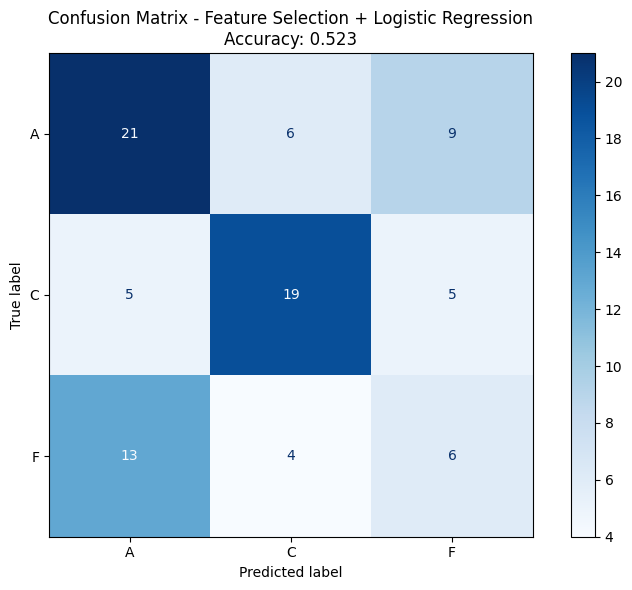

In [10]:
# ### Cell 8: Model 1 - Feature Selection + Logistic Regression

# %%
print("\n" + "="*60)
print("MODEL 1: Feature Selection + Logistic Regression")
print("="*60)

fs_logreg = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', SelectKBest(mutual_info_classif, k=30)),
    ('clf', LogisticRegression(max_iter=5000, C=0.1, class_weight='balanced', solver='saga'))
])

acc1, scores1 = evaluate_model(fs_logreg, X, y, groups, "Feature Selection + Logistic Regression")

# %% [markdown]


MODEL 2: XGBoost
Label encoding: {'A': np.int64(0), 'C': np.int64(1), 'F': np.int64(2)}

Training XGBoost...
  Fold 1: 0.611
  Fold 2: 0.667
  Fold 3: 0.556
  Fold 4: 0.412
  Fold 5: 0.529

=== XGBoost ===
Cross-validation scores: ['0.611', '0.667', '0.556', '0.412', '0.529']
Mean CV accuracy: 0.555 ± 0.086

              precision    recall  f1-score   support

           0       0.56      0.67      0.61        36
           1       0.69      0.62      0.65        29
           2       0.37      0.30      0.33        23

    accuracy                           0.56        88
   macro avg       0.54      0.53      0.53        88
weighted avg       0.55      0.56      0.55        88

Overall Accuracy: 0.557


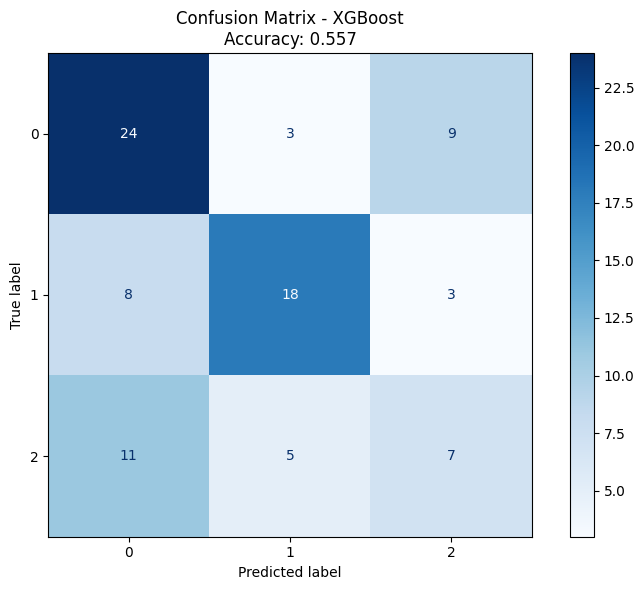

In [16]:
# ### Cell 9: Model 2 - XGBoost Classifier
# %%
from sklearn.preprocessing import LabelEncoder

print("\n" + "="*60)
print("MODEL 2: XGBoost")
print("="*60)

# Encode labels for XGBoost
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Store mapping for reference
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"Label encoding: {label_mapping}")

xgb_model = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', SelectKBest(f_classif, k=40)),
    ('clf', XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='mlogloss'
    ))
])

acc2, scores2 = evaluate_model(xgb_model, X, y_encoded, groups, "XGBoost")


MODEL 3: Gradient Boosting

Training Gradient Boosting...
  Fold 1: 0.667
  Fold 2: 0.611
  Fold 3: 0.667
  Fold 4: 0.294
  Fold 5: 0.471

=== Gradient Boosting ===
Cross-validation scores: ['0.667', '0.611', '0.667', '0.294', '0.471']
Mean CV accuracy: 0.542 ± 0.143

              precision    recall  f1-score   support

           A       0.54      0.56      0.55        36
           C       0.64      0.72      0.68        29
           F       0.39      0.30      0.34        23

    accuracy                           0.55        88
   macro avg       0.52      0.53      0.52        88
weighted avg       0.53      0.55      0.54        88

Overall Accuracy: 0.545


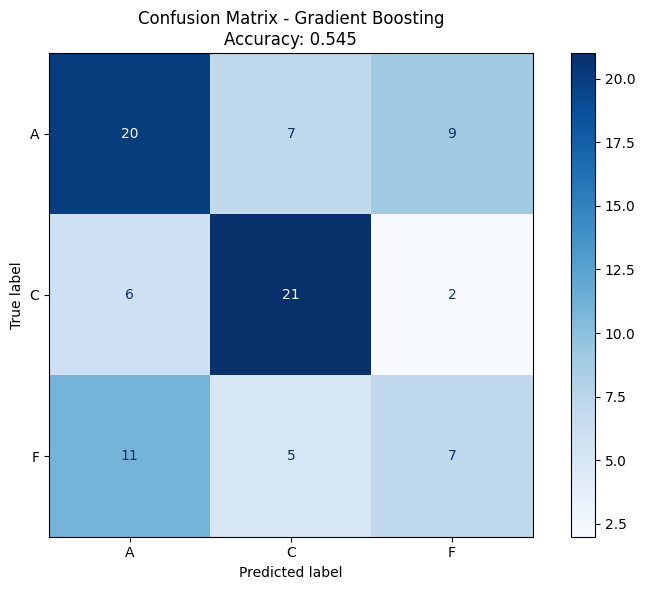

In [12]:
# ### Cell 10: Model 3 - Gradient Boosting

# %%
print("\n" + "="*60)
print("MODEL 3: Gradient Boosting")
print("="*60)

gb_model = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_classif, k=35)),
    ('clf', GradientBoostingClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        random_state=42
    ))
])

acc3, scores3 = evaluate_model(gb_model, X, y, groups, "Gradient Boosting")

# %% [markdown]


MODEL 4: SVM (RBF)

Training SVM (RBF)...
  Fold 1: 0.556
  Fold 2: 0.722
  Fold 3: 0.556
  Fold 4: 0.412
  Fold 5: 0.412

=== SVM (RBF) ===
Cross-validation scores: ['0.556', '0.722', '0.556', '0.412', '0.412']
Mean CV accuracy: 0.531 ± 0.115

              precision    recall  f1-score   support

           A       0.61      0.61      0.61        36
           C       0.62      0.69      0.66        29
           F       0.25      0.22      0.23        23

    accuracy                           0.53        88
   macro avg       0.50      0.51      0.50        88
weighted avg       0.52      0.53      0.53        88

Overall Accuracy: 0.534


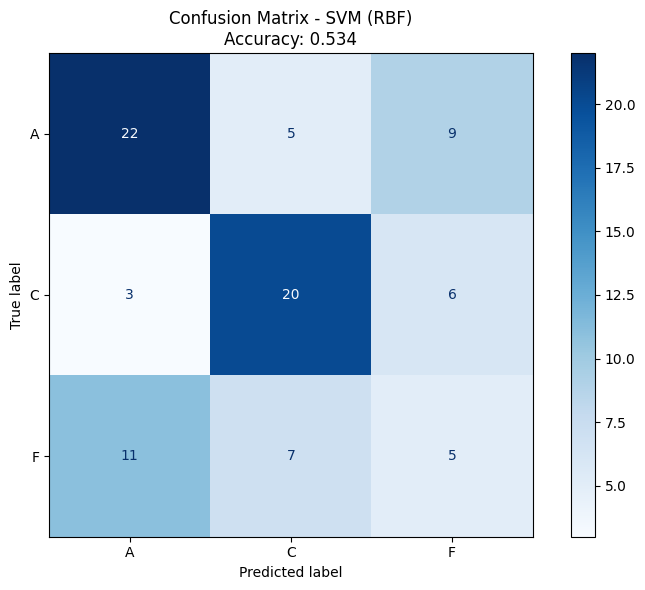

In [13]:
# ### Cell 11: Model 4 - SVM with RBF Kernel

# %%
print("\n" + "="*60)
print("MODEL 4: SVM (RBF)")
print("="*60)

svm_model = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_classif, k=30)),
    ('clf', SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42))
])

acc4, scores4 = evaluate_model(svm_model, X, y, groups, "SVM (RBF)")

# %% [markdown]


MODEL 5: Enhanced Random Forest

Training Enhanced Random Forest...
  Fold 1: 0.611
  Fold 2: 0.722
  Fold 3: 0.611
  Fold 4: 0.412
  Fold 5: 0.647

=== Enhanced Random Forest ===
Cross-validation scores: ['0.611', '0.722', '0.611', '0.412', '0.647']
Mean CV accuracy: 0.601 ± 0.103

              precision    recall  f1-score   support

           A       0.61      0.64      0.62        36
           C       0.70      0.72      0.71        29
           F       0.45      0.39      0.42        23

    accuracy                           0.60        88
   macro avg       0.59      0.58      0.58        88
weighted avg       0.60      0.60      0.60        88

Overall Accuracy: 0.602


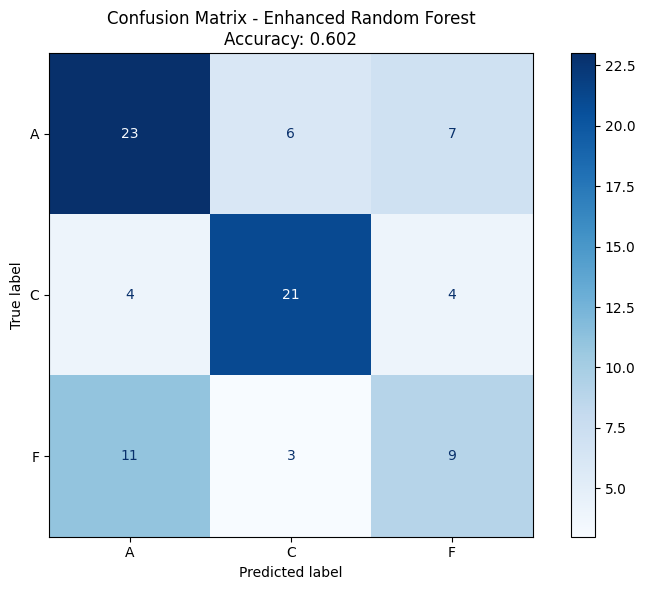

In [14]:
# ### Cell 12: Model 5 - Enhanced Random Forest

# %%
print("\n" + "="*60)
print("MODEL 5: Enhanced Random Forest")
print("="*60)

rf_enhanced = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', SelectKBest(mutual_info_classif, k=40)),
    ('clf', RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        class_weight='balanced',
        random_state=42
    ))
])

acc5, scores5 = evaluate_model(rf_enhanced, X, y, groups, "Enhanced Random Forest")

# %% [markdown]


MODEL 6: Ensemble Voting Classifier

Training Ensemble (Voting)...
  Fold 1: 0.556
  Fold 2: 0.722
  Fold 3: 0.667
  Fold 4: 0.353
  Fold 5: 0.529

=== Ensemble (Voting) ===
Cross-validation scores: ['0.556', '0.722', '0.667', '0.353', '0.529']
Mean CV accuracy: 0.565 ± 0.128

              precision    recall  f1-score   support

           A       0.56      0.64      0.60        36
           C       0.59      0.69      0.63        29
           F       0.54      0.30      0.39        23

    accuracy                           0.57        88
   macro avg       0.56      0.54      0.54        88
weighted avg       0.56      0.57      0.56        88

Overall Accuracy: 0.568


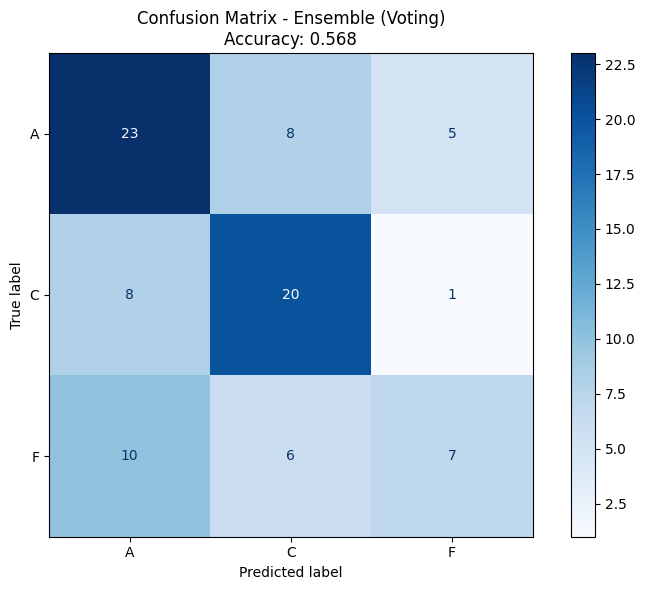

In [15]:
# ### Cell 13: Model 6 - Ensemble (Voting Classifier)

# %%
print("\n" + "="*60)
print("MODEL 6: Ensemble Voting Classifier")
print("="*60)

ensemble = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_classif, k=35)),
    ('clf', VotingClassifier(
        estimators=[
            ('xgb', XGBClassifier(n_estimators=150, max_depth=4, learning_rate=0.05, random_state=42, eval_metric='mlogloss')),
            ('rf', RandomForestClassifier(n_estimators=150, max_depth=8, random_state=42, class_weight='balanced')),
            ('gb', GradientBoostingClassifier(n_estimators=150, max_depth=4, learning_rate=0.05, random_state=42))
        ],
        voting='soft'
    ))
])

acc6, scores6 = evaluate_model(ensemble, X, y, groups, "Ensemble (Voting)")

# %% [markdown]


PERFORMANCE SUMMARY
Model                          Mean Acc     Std        Best      
------------------------------------------------------------
Enhanced Random Forest         0.602        0.103      0.722
Ensemble Voting                0.568        0.128      0.722
XGBoost                        0.557        0.086      0.667
Gradient Boosting              0.545        0.143      0.667
SVM (RBF)                      0.534        0.115      0.722
Feature Selection + LogReg     0.523        0.094      0.667


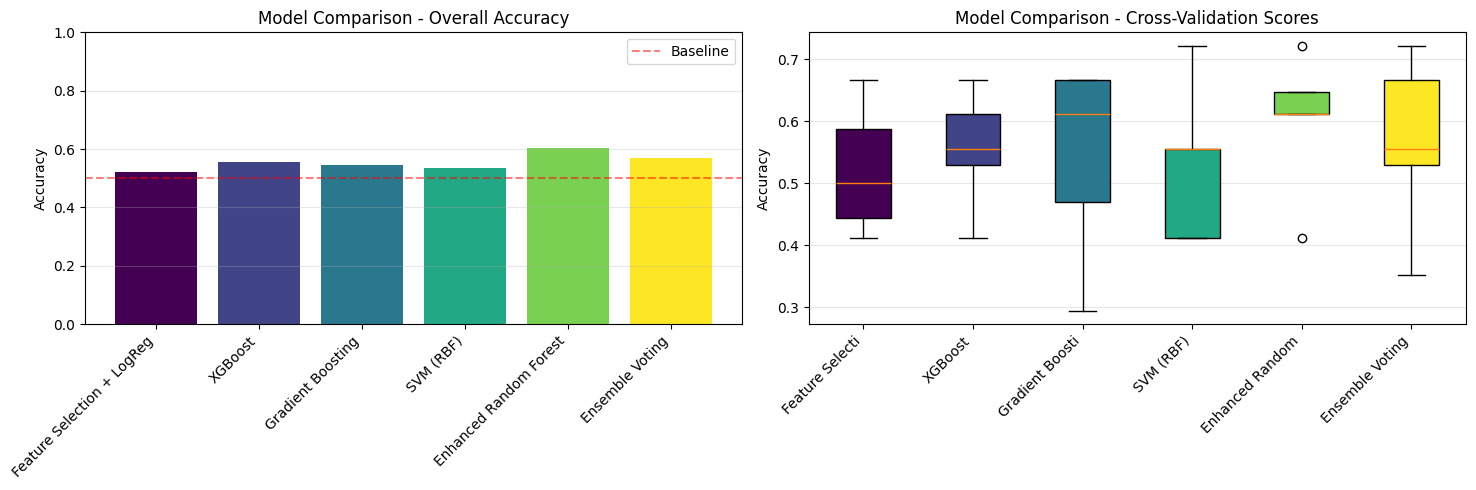


FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features:
Rank   Feature                                  Importance  
------------------------------------------------------------
1      alpha_std                                0.0401
2      alpha_max                                0.0351
3      high_alpha_std                           0.0301
4      low_alpha_max                            0.0278
5      theta_min                                0.0275
6      ch1_skew                                 0.0245
7      theta_alpha_ratio                        0.0244
8      alpha_mean                               0.0236
9      theta_std                                0.0236
10     theta_beta_ratio                         0.0233
11     low_alpha_mean                           0.0231
12     low_beta_std                             0.0218
13     low_alpha_std                            0.0217
14     theta_mean                               0.0195
15     low_high_alpha_ratio                   

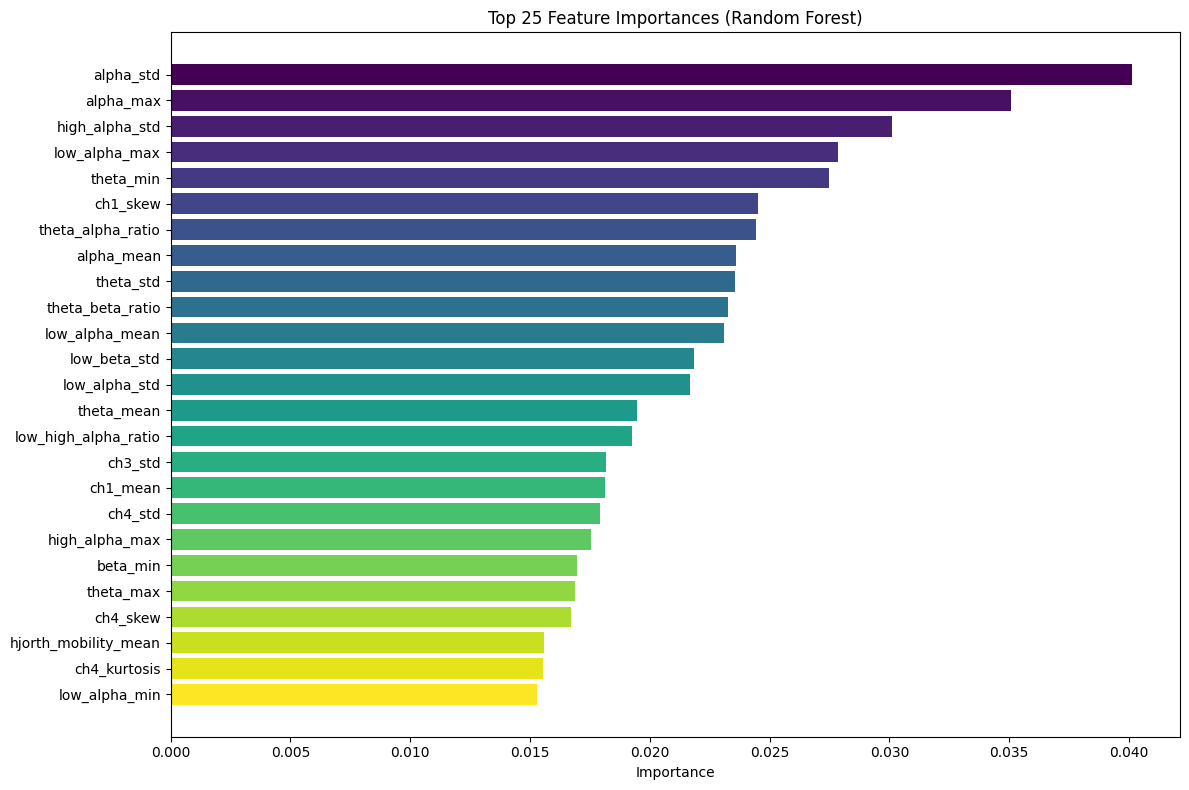


FEATURE DISTRIBUTION ANALYSIS


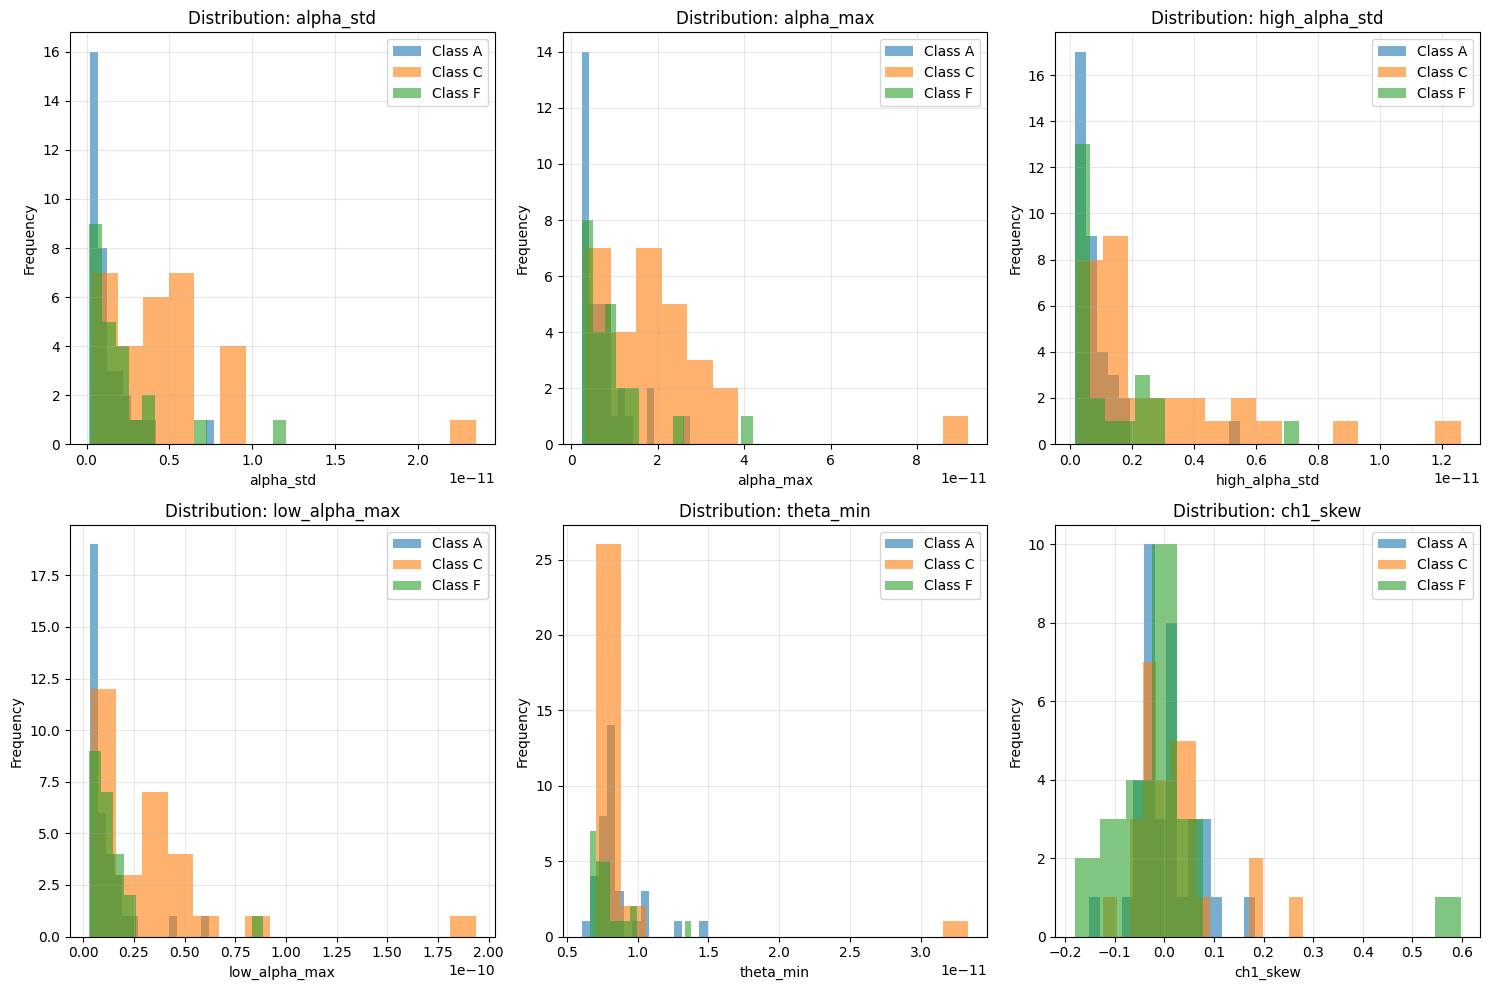

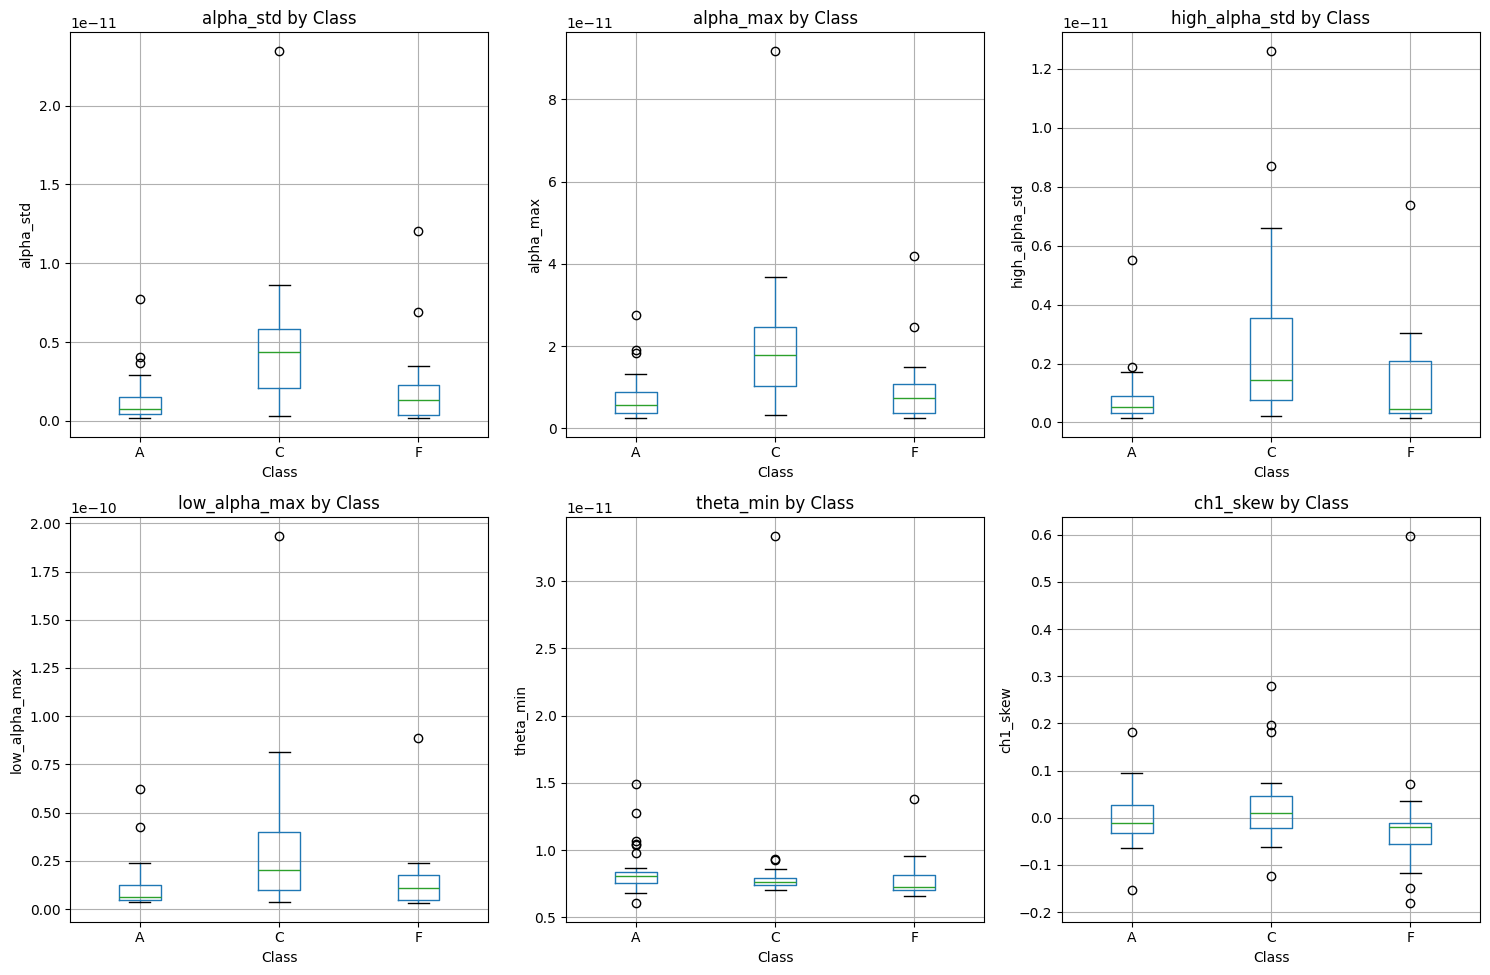

✓ Analysis complete!


In [17]:
# ### Cell 14: Performance Summary and Comparison

# %%
print("\n" + "="*60)
print("PERFORMANCE SUMMARY")
print("="*60)

results = {
    'Feature Selection + LogReg': (acc1, scores1),
    'XGBoost': (acc2, scores2),
    'Gradient Boosting': (acc3, scores3),
    'SVM (RBF)': (acc4, scores4),
    'Enhanced Random Forest': (acc5, scores5),
    'Ensemble Voting': (acc6, scores6)
}

# Print summary table
print(f"{'Model':<30} {'Mean Acc':<12} {'Std':<10} {'Best':<10}")
print("-" * 60)
for name, (acc, scores) in sorted(results.items(), key=lambda x: x[1][0], reverse=True):
    print(f"{name:<30} {acc:.3f}        {np.std(scores):.3f}      {max(scores):.3f}")

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot of accuracies
names = list(results.keys())
accs = [results[name][0] for name in names]
colors = plt.cm.viridis(np.linspace(0, 1, len(names)))

ax1.bar(range(len(names)), accs, color=colors)
ax1.set_xticks(range(len(names)))
ax1.set_xticklabels(names, rotation=45, ha='right')
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Comparison - Overall Accuracy')
ax1.set_ylim([0, 1])
ax1.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Baseline')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Box plot of fold scores
fold_data = [results[name][1] for name in names]
bp = ax2.boxplot(fold_data, labels=[n[:15] for n in names], patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax2.set_xticklabels([n[:15] for n in names], rotation=45, ha='right')
ax2.set_ylabel('Accuracy')
ax2.set_title('Model Comparison - Cross-Validation Scores')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# %% [markdown]
# ### Cell 15: Feature Importance Analysis

# %%
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Train RF on full data to get feature importance
rf_full = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
rf_full.fit(X_scaled, y)

feature_names = df.drop(columns=['subject', 'label']).columns
importances = rf_full.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nTop 20 Most Important Features:")
print(f"{'Rank':<6} {'Feature':<40} {'Importance':<12}")
print("-" * 60)
for i in range(min(20, len(indices))):
    print(f"{i+1:<6} {feature_names[indices[i]]:<40} {importances[indices[i]]:.4f}")

# Plot feature importances
fig, ax = plt.subplots(figsize=(12, 8))
top_n = 25
indices_top = indices[:top_n]
ax.barh(range(top_n), importances[indices_top], color=plt.cm.viridis(np.linspace(0, 1, top_n)))
ax.set_yticks(range(top_n))
ax.set_yticklabels([feature_names[i] for i in indices_top])
ax.set_xlabel('Importance')
ax.set_title(f'Top {top_n} Feature Importances (Random Forest)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# %% [markdown]
# ### Cell 16: Feature Distribution Analysis

# %%
print("\n" + "="*60)
print("FEATURE DISTRIBUTION ANALYSIS")
print("="*60)

# Plot distributions of top features by class
top_features = [feature_names[i] for i in indices[:6]]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feat in enumerate(top_features):
    ax = axes[idx]
    for label in np.unique(y):
        data = df[df['label'] == label][feat]
        ax.hist(data, alpha=0.6, label=f'Class {label}', bins=15)
    ax.set_xlabel(feat)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution: {feat}')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Box plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feat in enumerate(top_features):
    ax = axes[idx]
    df.boxplot(column=feat, by='label', ax=ax)
    ax.set_title(f'{feat} by Class')
    ax.set_xlabel('Class')
    ax.set_ylabel(feat)

plt.suptitle('')
plt.tight_layout()
plt.show()

print("✓ Analysis complete!")